# Time-Series 101: Reading the Pulse of the World

Welcome to **Time-Series 101**, an educational notebook designed to introduce you to the core concepts of time-series analysis, from lag-based modeling to frequency-domain intuition — all using real-world COVID-19 case data from Barcelona.

> 📍 This notebook is beginner-friendly but mathematically curious. Perfect for anyone who wants to go beyond tutorials and build strong intuition.

---

## What's Inside?

-  **Time-Domain Intuition**: Learn how today's values depend on previous days using lag structures and autoregressive models.
-  **GRU Forecasting Example**: Train a simple GRU (Gated Recurrent Unit) model to predict daily COVID-19 cases.
-  **Frequency-Domain Perspective**: Explore how seasonality and cycles are captured using spectral tools (coming soon).
-  **Conceptual Insights**: Theory meets hands-on coding, with explanations alongside code blocks.
- ️ **Modular Helpers**: Preprocessing, training, and evaluation are split into reusable functions for clarity and reuse.

---


In [4]:
from helpers import preprocess_series, get_dataloaders, train_model, evaluate_model
from models.blog_one_models import GRUModel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [10]:
# Load and prepare data
df = pd.read_csv('../../data/Time-Series-101-Data/spain-covid-data.csv')
df['Fecha'] = pd.to_datetime(df['Fecha'])
cases = df[df['provincia'] == 'Barcelona'].sort_values('Fecha')['Casos'].fillna(0).values.astype(np.float32)

X_train, y_train, X_test, y_test, _, scaler_y = preprocess_series(cases)
train_loader = get_dataloaders(X_train, y_train)

In [11]:
# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUModel()
trained_model = train_model(model, train_loader, n_epochs=40, device=device)

Epoch 10/40 - Loss: 0.0176
Epoch 20/40 - Loss: 0.0128
Epoch 30/40 - Loss: 0.0091
Epoch 40/40 - Loss: 0.0076


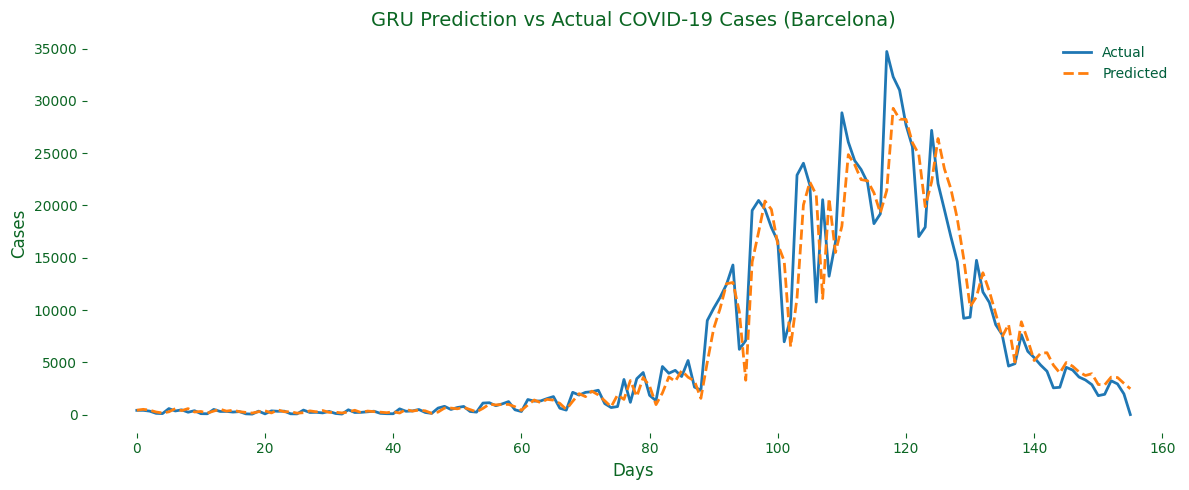

In [22]:
# Evaluate
y_true, y_pred = evaluate_model(trained_model, X_test, y_test, scaler_y, device)

plt.figure(figsize=(12, 5))

# Colors
text_color = "#0b6623"          # Dark green (good contrast on both themes)

# Plot lines
plt.plot(y_true, label="Actual", linewidth=2)
plt.plot(y_pred, label="Predicted", linestyle="--", linewidth=2)

# Labels and title with dark green
plt.title("GRU Prediction vs Actual COVID-19 Cases (Barcelona)", fontsize=14, color=text_color)
plt.xlabel("Days", fontsize=12, color=text_color)
plt.ylabel("Cases", fontsize=12, color=text_color)

# Set tick label colors
plt.tick_params(axis='x', colors=text_color)
plt.tick_params(axis='y', colors=text_color)

# Optional: Remove borders
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Legend
plt.legend(facecolor='none', edgecolor='none', labelcolor='#005f3c')

# Save with transparent background
plt.tight_layout()
plt.savefig("./assets/gru_prediction_plot.png", dpi=300, transparent=True)
plt.show()
